# Building and Exploring a Map of Reddit with Python

The goal of this notebook is to build and analyse a map of the 10,000 most popular subreddits on [Reddit](https://www.reddit.com). To do this we need a means to measure the similarity of two subreddits. In a great [article on FiveThirtyEight](https://fivethirtyeight.com/features/dissecting-trumps-most-rabid-online-following/) Trevor Martin did an analysis of subreddits by considering the overlaps of users commenting on two different subreddits. Their interest was in using vector algebra on representative vectors to look at, for example, what happens if you remove ``r/politics`` from ``r/The_Donald``. Our interest is a little broader -- we want to map out and visualize the space of subreddits, and attempt to cluster subreddits into their natural groups. With that done we can then explore some of the clusters and find interesting stories to tell.

The first step in all of this is acquiring the relevant data on subreddits. Reddit user ``u/Stuck_in_the_Matrix`` provided a vast amount of reddit comment data on Google's BigQuery service, and the FiveThirtyEight authors posted their code to extract the relevant commenter overlap information via BigQuery queries. I have placed the (slightly modified) code for BigQuery [on github](https://github.com/lmcinnes/subreddit_mapping/BigQuery_queries.sql). The result is a file with over 15 million counts of pairwise commenter overlap between subreddits [available here](https://github.com/lmcinnes/subreddit_mapping/subreddit-overlap.archive.bz2). This will be the starting point for our analysis.

## Getting set up

To build a map of subreddits we'll need to get relevant data, and massage it into a form that we can use creating a map. We begin by loading all the relevant Python modules we will require.

In [1]:
import pandas as pd
import scipy.sparse as ss
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.base import BaseEstimator
from sklearn.utils import check_array
from os.path import isfile
import subprocess

Next we need to read in the overlap data, which we can do easily with [pandas](http://pandas.pydata.org/). The result is a dataframe, each row providing a from subreddit, a to subreddit, and the number of unique commenters that the two subreddits have in common. A call to ``head`` shows is the first 5 entries of the table.

In [2]:
raw_data = pd.read_csv('subreddit-overlap')

In [3]:
raw_data.head()

,t1_subreddit,t2_subreddit,NumOverlaps
0,roblox,spaceengineers,20
1,madlads,Guitar,29
2,Chargers,BigBrother,29
3,NetflixBestOf,celebnsfw,35
4,JoeRogan,Glitch_in_the_Matrix,28


This table has a total of over 50,000 unique subreddits. That's too many to visualise, and in practice many of the less popular subreddits with sparse overlaps will act as noise, muddying our later analysis. That means that later in our analysis we will want to narrow our focus on just the top 10,000 subreddits. To make this easy to do I will rank the subreddits so that they are indexed in order of popularity. For this purpose I will define popularity as the total number of unique commenters in a subreddit -- the more unique commenters, the more popular the subreddit. We can estimate this from our table by summing the total number of overlaps for each subreddit. Pandas makes this easy; first we group the data by subreddit, then select ``NumOverlaps`` and sum those for each group. The result is a Series indexed by subreddit of the sums of overlaps for that subreddit. Sorting this Series and extracting the index will give us a ranking of subreddits by approximate popularity.

In [4]:
subreddit_popularity = raw_data.groupby('t2_subreddit')['NumOverlaps'].sum()
subreddits = np.array(subreddit_popularity.sort_values(ascending=False).index)

Our next step is going to be to pivot the data into a matrix such that rows and columns are both indexed by subreddits, and the entry at position (i,j) is the number of overlaps bwteen the i<sup>th</sup> and j<sup>th</sup> subreddits. We could do this in pandas via the ``pivot`` method, but the result will be quite large and consume a lot of memory. Since most of the entries of such a matrix will be zero a better option is to use a sparse matrix data structure which can be operated on as if it were a matrix, but only stores the non-zero entries. Since sparse matrices are numerically indexed we'll need a mapping from (popularity ranked) subreddits to 0-up integer indices. We can quickly and easily build a Python dictionary to do this, providing us with the ability to look up a numeric index for any given subreddit.

In [5]:
index_map = dict(np.vstack([subreddits, np.arange(subreddits.shape[0])]).T)

Now we need to build the matrix. [Scipy](https://www.scipy.org/scipylib/index.html) provides good support for sparse matrices in a number of formats. For matrix construction the most suitable format is called COO format (short for coordinate format). This format requires us to specify triples of row, column, and value for each non-zero entry in the matrix. The COO matrix constructor accepts this as a triple of arrays: the first array is the values, the second and third are arrays of row and column indices. This all gets zipped together to create a sparse matrix. Pulling the relevant arrays out of our data table is straight forward since each array corresponds to a column of the table -- the only work required is to use our subreddit-to-integer-index map to convert the subreddit names in the table into numeric row and column indexes.

In [6]:
count_matrix = ss.coo_matrix((raw_data.NumOverlaps, 
                              (raw_data.t2_subreddit.map(index_map),
                               raw_data.t1_subreddit.map(index_map))),
                             shape=(subreddits.shape[0], subreddits.shape[0]),
                             dtype=np.float64)

I can now consider each row of the matrix as a vector of information describing a subreddit in terms of its relations to other subreddits. Comparisons between these vectors are a little more difficult since the counts are on very different scales: AskReddit has large overlaps with many subreddits, since it has so many comments; meanwhile niche subreddits have smaller overlaps simply because they have few commenters. In practice I want to compare the vectors *relative* overlaps because it is the overlaps that are large *for the average overlap size of that subreddit* that will tell us the most about what makes a given subreddit different from others. We can achieve this by row-normalizing, dividing each subreddit vector by the sum of entries in the vector. You can think of the result as empirical conditional probabilities: given we are looking at a particular subreddit (our row of choice), what is the probability that it shares a commenter with another subreddit (our column of choice)? That's what the given matrix entry should tell us.

Computationally this is easy thanks for [scikit-learn](http://scikit-learn.org/stable/), which provides a convenient ``normalize`` function (which can operate on sparse matrices). We need to specify that we are using the so called "l1-norm", and then scikit-learn will take care of the rest. The one caveat is that while COO format was great for matrix construction it is much less efficient for row-wise operations like this. To make it easier for scikit-learn we'll convert the matrix to CSR format (short for Compact Sparse Row) which has efficient row-wise computation.

In [7]:
conditional_prob_matrix = count_matrix.tocsr()
conditional_prob_matrix = normalize(conditional_prob_matrix, norm='l1', copy=False)

## Converting subreddit vectors into a map

Now that we have comparable vectors, perhaps we should start comparing subreddits? Not quite. Each vector is 56187-dimensional, which is a little large to work with easily. In practice we don't expect that our data is intrinsically that high dimensional, which means there is a lot of redundancy built into those 56187-dimensional vectors. To make things easier to work with we're going to use a truncated [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) to reduce down to 500-dimensional vectors. That sounds fancy, but really it amounts to finding a matrix of 500-dimensional vectors from which we can (almost) reconstruct the full 56187-dimensional vectors. This is just (slightly lossy) information compression. The Singular Value Decomposition part simply refer to the linear algebra technique that makes finding the optimal such compressed form computationally efficient.

Once again scikit-learn comes to our aid, providing a truncated SVD implementation that operates on sparse matrices. That means that getting our compressed representation is a single line of code.

The next step is a little sleight of hand. The correct measure of similarity between these vectors is [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Very soon I'm going to want to work with distances rather than similarities. There is such a thing as cosine distance, but that is not really a distance metric which would break some of the algorithms I want to apply. The correct distance measure is something called angular distance (essentially the size of the angle between the vectors). Fortunately the euclidean distance between normalized (by euclidean norm) vectors is equivalent to angular distance. Therefore I'll normalize the vectors now, and thereafter we can use euclidean distance knowing that it is actually effective angular distance in practice. Again scikit-learn's ``normalize`` function does the job, this time with the "l2-norm" which is another name for the euclidean norm.

In [8]:
reduced_vectors = TruncatedSVD(n_components=500,
                               random_state=1).fit_transform(conditional_prob_matrix)
reduced_vectors = normalize(reduced_vectors, norm='l2', copy=False)

Now we need to convert the subreddit vectors into a map. What does this mean? It means we need to generate an (x,y) coordinate pair for each subreddit. This sounds like another dimension reduction step -- this time reducing down to only 2-dimensional vectors. Why did we not just use the SVD above to do that for us? The SVD approach to dimension reduction performs a *linear* dimension reduction, which means that if the data lives in some flat hyperplane in high dimensional space it will do an excellent job, If, however, the data lives on several warped curving hypersurfaces with disjoint components ... well a linear approach to that will not work so well. Given that, with 56,000 dimensions, there was a lot of redundant information in the vectors, we could afford a linear approximation to carve away a lot of the redundancy. To get down to just two dimensions, however, we are going to need to worry about the distorted curvy hypersurfaces if we want to get a good representation. That means we need to start considering non-linear dimension reduction techniques (sometimes called manifold learning techniques, since the goal is to learn the curvy hypersurface, called a manifold in math speak, that the data lies on). I've chosen to use LargeVis, a relatively recent technique, very closely related to the popular t-SNE algorithm. In fact, LargeVis essentially does the same thing mathematically as t-SNE, but uses some clever tricks to get a more efficient computational approach, which in turn helps it to find a better answer.

There aren't (currently) any LargeVis implementations for Python; the authors of the LargeVis paper have a C++ implementation (with Python bindings that work only with Python2), which is what we'll be using. You can get it directly from [their LargeVis github repo](https://github.com/lferry007/LargeVis). Since scikit-learn has the best machine learning API around I will wrap the code to farm data out and back using scikit-learn's ``BaseEstimator`` class so that I can just keep using a familiar API.

In [9]:
class LargeVis (BaseEstimator):
    
    def __init__(self, n_components=2, perplexity=50.0, gamma=5,
                 layout_samples=None, n_neighbors=None, negative_samples=5,
                 alpha=1.0, n_cores=4, knn_prop=3, trees=50):
        self.n_components = n_components
        self.perplexity = perplexity
        self.layout_samples = layout_samples
        self.alpha = alpha
        self.n_cores = n_cores
        self.knn_prop = knn_prop
        self.negative_samples = negative_samples
        self.n_neighbors = n_neighbors
        self.gamma = gamma
        self.trees = trees
        if self.n_neighbors is None:
            self.n_neighbors = int(self.perplexity * 3)


    def fit_transform(self, X, y=None):
        
        if self.layout_samples is None:
            layout_samples = X.shape[0] / 100.0
        else:
            layout_samples = self.layout_samples
            
        X = check_array(X, dtype=np.float64)
        np.savetxt('/tmp/largevis_input', 
                   X, header='{} {}'.format(*X.shape), 
                   comments='')
        subprocess.check_call(['/home/leland/Source/LargeVis/Linux/LargeVis',
                               '-input', '/tmp/largevis_input',
                               '-output', '/tmp/largevis_output',
                               '-outdim', str(self.n_components),
                               '-perp', str(self.perplexity),
                               '-samples', str(layout_samples),
                               '-gamma', str(self.gamma),
                               '-prop', str(self.knn_prop),
                               '-trees', str(self.trees),
                               '-neigh', str(self.n_neighbors),
                               '-alpha', str(self.alpha),
                               '-neg', str(self.negative_samples),
                               '-threads', str(self.n_cores)])
        self.embedding_ = np.loadtxt('/tmp/largevis_output', skiprows=1)
        return self.embedding_
    
    def fit(self, X, y=None):
        self.fit_transform(X)
        return self

Now that we have LargeVis in Python the next step is to run it. It is at this point that I'll prune down to just the top 10,000 subreddits, only passing that many vectors to LargeVis. Since LargeVis is a randomized algorithm the results are never *exactly* the same between any two runs. For the sake of my own sanity in discussing what the map looks like I have set code up to cache a result and load that if it is available so that I can get a consistent map when re-running the notebook.

In [10]:
if isfile('largevis_subreddit_map.npy'):
    subreddit_map = np.load('largevis_subreddit_map.npy')
else:
    subreddit_map = LargeVis().fit_transform(reduced_vectors[:10000])
    np.save('largevis_subreddit_map.npy', subreddit_map)

Now that we have a set of coordinates for each subreddit we can put that data into a pandas dataframe and join it with the actual names of the subreddits so that we can associate the actual subreddit with each point in 2-dimensional space. We can look at the head of the resulting dataframe and see that we do indeed have x and y coordinates for each subreddit.

In [11]:
subreddit_map_df = pd.DataFrame(subreddit_map[:10000], columns=('x', 'y'))
subreddit_map_df['subreddit'] = subreddits[:10000]
subreddit_map_df.head()

,x,y,subreddit
0,-2.469311,2.295230,AskReddit
1,-2.801981,2.136050,pics
2,-2.734101,2.063090,funny
3,-3.564055,2.174888,todayilearned
4,-5.986312,2.277558,worldnews


## Clustering the Map

While we now have a map it does have 10,000 data points in it and is going to be a little hard to make sense of. We can make that task a little easier by clustering the subreddits in the map, allowing us to look at a small(ish) number of groups of subreddits that each clump together in the map.

For clustering I've chosen to use the HDBSCAN\* clustering algorithm. HDBSCAN\* is a density based clustering algorithm -- that means it view clusters as dense areas that are separated from other clusters by less dense areas. It also means that it can find clusters that are arbitrary shapes (unlike K-Means), and supports a notion of "noise" (data points that are outliers, not necessarily in any cluster). A final advantage is that it does not require the specification of the number of clusters to be found -- I honestly don't know how many clumps of subreddits to expect, so having to state that up front for the benefit of the clustering algorithm is hard.

The Python implementation of HDBSCAN\*, [hdbscan](https://github.com/scikit-learn-contrib/hdbscan), is fully scikit-learn compatible, so we get to use a familiar scikit-learn API, and thanks to spatial indexing acceleration it can whip through all 10,000 data points in a fraction of second.

In [12]:
import hdbscan

In [13]:
clusterer = hdbscan.HDBSCAN(min_samples=5, 
                            min_cluster_size=20).fit(subreddit_map)
cluster_ids = clusterer.labels_

We'll save the clusterer object for later -- it has some other properties we will explore. The cluster labels are the assignments of points to clusters (with a label of -1 for points that are considered noise). We can simply add these to our existing data frame as a new column, allowing us to associate each subreddit with a cluster number.

In [14]:
subreddit_map_df['cluster'] = cluster_ids

## Visualization

Now that we have subreddits mapped and clustered, the next step is to actually visualise the results so that we can see what is going on. Since we have 10,000 points a basic scatterplot is going to be very busy and have a great deal of overplotting. Furthermore while we can plot a point for each subreddit we won't know which subreddits they represent, and filling the screen with overplotted text is certainly not the answer.

To get around these problems I decided to use [Bokeh](http://bokeh.pydata.org/en/latest/) for my initial visualisation. Bokeh is a Python plotting library that supports interactive plots in the browser. This means we can zoom in on the plot and pan around as needed. Better still we can add tooltips showing which subreddit points represent as we hover over them.

Bokeh is a large and powerful library. There are good tutorials on Bokeh available, so I won't explain everything Bokeh can do. Instead I'll just load the parts of it that we'll need for our interactive scatterplot map of subreddits.

In [15]:
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource, CustomJS, value
from bokeh.models.mappers import LinearColorMapper
from bokeh.palettes import plasma
from collections import OrderedDict

output_notebook()
# To output to a static html file, comment out the previous
# line, and uncomment the line below.
# output_file('subreddit_interactive_map.html')

Loading BokehJS ...

Now that we have Bokeh loaded it is time to build the plot. There's a lot going on in the next notebook cell, but each piece is relatively straightforward; I'll try to explain what is going on in each chunk of code. 

First we need some colour. We can use the clusters for that, but that means we need to map cluster numbers to colours and reserve gray for noise points. We can construct a palette and then use the ``LinearColorMapper`` for this. There is also some code to set a fill_alpha value which we will come back to later. 

Next we create a ``ColumnDataSource``. This just connects up our dataframe with bokeh so it can embed data (like the names of the subreddits!) directly in the html for the plot (and not have to round trip back to Python to get that information). We also have some custom javascript for handling alpha values -- again, we'll come back to this.

The next step is to create a figure to plot to, and then add a hover tool (which we wire up to display the subreddit and cluster).  We then add circles to the figure, taking x, y and color values for the circles from the ``ColumnDataSource`` we created. Then there is some custom callbacks which we'll skip over for now, and the rest, prior to ``show(plot)`` is just customising the display style a little.

The result is a scatterplot, colored by cluster, which we can zoom and pan around in, complete with tooltips. The plot itself is pure html and javascript, and we can embed it in a webpage independent of any Python -- it is standalone at this point.

One catch is that we set a fairly low alpha channel level (the translucency of points) so that we can see dense areas when zoomed out due to all the overplotting of points. If we were to zoom in while keeping that same alpha channel all the points would be very pale and hard to see. I was expecting that fixing this would be a very difficult task -- how does one dynamically alter the alpha value as you zoom in? It turns out to be surprsingly straightforward in Bokeh. By adding a ``fill_alpha`` value to the dataframe (and hence the ``ColumnDataSource``) we can set the alpha value from the ``ColumnDataSource``. Bokeh also let's us add custom callbacks when the zoom level changes, so we simply update the alpha values based on the bounds of the zoomed area.

In [16]:
# Construct a color palette and map clusters to colors
palette = ['#777777'] + plasma(cluster_ids.max())
colormap = LinearColorMapper(palette=palette, low=-1, high=cluster_ids.max())
color_dict = {'field': 'cluster', 'transform': colormap}

# Set fill alpha globally
subreddit_map_df['fill_alpha'] = np.exp((subreddit_map.min() - 
                                         subreddit_map.max()) / 5.0) + 0.05

# Build a column data source
plot_data = ColumnDataSource(subreddit_map_df)

# Custom callback for alpha adjustment
jscode="""
    var data = source.data;
    var start = cb_obj.start;
    var end = cb_obj.end;
    alpha = data['fill_alpha']
    for (i = 0; i < alpha.length; i++) {
         alpha[i] = Math.exp((start - end) / 5.0) + 0.05;
    }
    source.trigger('change');
"""

# Create the figure and add tools
bokeh_figure = figure(title='A Map of Subreddits',
                   plot_width = 700,
                   plot_height = 700,
                   tools= ('pan, wheel_zoom, box_zoom,'
                           'box_select, resize, reset'),
                   active_scroll=u'wheel_zoom')

bokeh_figure.add_tools( HoverTool(tooltips = OrderedDict([('subreddit', '@subreddit'),
                                                       ('cluster', '@cluster')])))

# draw the subreddits as circles on the plot
bokeh_figure.circle(u'x', u'y', source=plot_data,
                 fill_color=color_dict, line_color=None, fill_alpha='fill_alpha',
                 size=10, hover_line_color=u'black')

bokeh_figure.x_range.callback = CustomJS(args=dict(source=plot_data), code=jscode)
bokeh_figure.y_range.callback = CustomJS(args=dict(source=plot_data), code=jscode)

# configure visual elements of the plot
bokeh_figure.title.text_font_size = value('18pt')
bokeh_figure.title.align = 'center'
bokeh_figure.xaxis.visible = False
bokeh_figure.yaxis.visible = False
bokeh_figure.grid.grid_line_color = None
bokeh_figure.outline_line_color = '#222222'

# display the figure
show(bokeh_figure);

And there is our map. It's worth taking some time to hover over points and explore how the different subreddits got placed, or zoom in on clusters and see the internal structure. A note of warning: this is the unfiltered internet and some (many?) subreddits have unpleasant names. The unpleasant areas of reddit do tend to cluster together in the map; in this case much of it at the top of the map.

## Exploring the Clusters

After you've spent a while exploring the interactive map, and looking at how the subreddits group up, one starts to want to explore things in a little more detail -- look at individual clusters, and possibly produce static plots with the subreddits labelled so as to tell a story. We can certainly do that, but we will need a little infrastructure first.

Given the name of a subreddit we would like to find the cluster it is in, and then get some bounds so we can just display that cluster (and perhaps some of the nearby points for context). To make this easier we'll create a cluster bounds function. All that we have to do is find the subreddit in our dataframe, extract the cluster it is in, and then find the min and max x and y values of points in that cluster. We'll pad those bounds out a little bit to ensure we give the cluster a little context.

In [17]:
def cluster_bounds(dataframe, subreddit):
    # Find the cluster the subreddit belongs to
    cluster = dataframe.cluster[
        dataframe.subreddit == subreddit].values[0]
    if cluster == -1:
        warn('This subreddit was lost as noise and not in any cluster')
        
    # Extract the dubset of the dataframe that is the cluster
    sub_dataframe = dataframe[dataframe.cluster == cluster]
    
    x_min = sub_dataframe.x.min()
    x_max = sub_dataframe.x.max()
    x_padding = (x_max - x_min) * 0.5
    x_min -= x_padding
    x_max += x_padding
    
    y_min = sub_dataframe.y.min()
    y_max = sub_dataframe.y.max()
    y_padding = (y_max - y_min) * 0.5
    y_min -= y_padding
    y_max += y_padding

    return x_min, x_max, y_min, y_max

Next, given bounds, we would like to subselect out the data that lies within those bounds. At the very least this contains the cluster containing the subreddit we selected, but (especially since we padded the bounds) it may contain other data points from outside the cluster as well. We can create a simple function to extract all the points in the dataframe that lie within a given set of bounds.

In [18]:
def data_in_bounds(dataframe, bounds):
    return dataframe[
        (dataframe.x > bounds[0]) &
        (dataframe.x < bounds[1]) &
        (dataframe.y > bounds[2]) &
        (dataframe.y < bounds[3])
    ]

Bokeh did an excellent job of the interactive map; for static plots however the venerable Python standard plotting library [matplotlib](http://matplotlib.org/) remains hard to beat in terms of power and flexibility. That means loading up and initializing a slightly different set of visualisation tools.

In [19]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

import seaborn as sns
import adjustText
%matplotlib inline

sns.set_context('poster')
sns.set_style('white')

If you are going to do something more than a few times you should just write a function to do it. We are almost certainly going to want to plot clusters for many different subreddits so it makes sense to create the function to do so. The parameters should simply be the subreddit map dataframe and the name of a subreddit to look for.

This is a big complicated looking function, but that's mostly just a matter of getting all the visual styling right to present the best possible result. I'll break it down into constituent parts (as we did for the Bokeh plot) to explain what is going on at each stage.

As with Bokeh, we build a colormap (using seaborn to get an identical palette). We are going to have two plots; one is the zoomed in area of the cluster, and the other is a smaller plot of the full map with a zoom box identifying where the zoomed in plot fits into the bigger picture. We'll use gridspec to make laying out the plots easier. We then set about constructing the first plot, getting the cluster bounds (with a suitable error in the case of a bad subreddit name), then getting the data subset, and plotting a scatter plot of that data. 

Next we add the text labels. To ensure things don't get too messy we will use a sample of subreddit names if we have more than 50 text labels to add. Of course it is quite likely that the text labels will overlap. Moving labels so they don't overlap, and then adding arrows pointing to the data point they refer to is a complicated and tedious thing to get right. Fortunately [adjustText](https://github.com/Phlya/adjustText) makes that trivial. 

The second plot is more straightforward: we simply plot all the data, and then add a rectangle showing the region the larger plot encompasses. Finally we need some connecting lines showing the zoom from the region of the full map to the cluster plot. We can make use of matplotlib's transforms to get all the coordinates right (switching between data, axis, and figure coordinates) and draw the relevant lines. That gives us the plot we want.

In [20]:
def plot_cluster(dataframe, subreddit):
    # Build a color map to match the Bokeh plot
    colormap = dict(zip(
        np.unique(dataframe.cluster),
        ['#777777'] + sns.color_palette('plasma', dataframe.cluster.max() + 1).as_hex()
    ))
    subregion_defined = True
    
    # Figure and gridspec to layout axes
    fig = plt.figure()
    gs = GridSpec(3, 3)
    
    # First axes, spanning most of the figure
    # Contains just the points in a region 
    # around the points in the cluster
    ax1 = plt.subplot(gs[:,:2])
    try:
        bounds = cluster_bounds(dataframe, subreddit)
    except IndexError:
        ax1.text(0.5, 0.5, 'Subreddit {} not found!'.format(subreddit), 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax1.transAxes, fontsize=18)
        subregion_defined = False
    
    if subregion_defined:
        to_plot = data_in_bounds(dataframe, bounds)
        ax1.scatter(to_plot.x, to_plot.y, c=to_plot.cluster.map(colormap), s=30, alpha=0.5)
    
        # We want to add text labels. We subsample up to 50 labels
        # And then use adjustText to get them non-overlapping
        text_elements = []
        for row in to_plot.sample(n=min(len(to_plot),50), random_state=0).values:
            if row[2] != subreddit:
                text_elements.append(ax1.text(row[0], row[1], row[2], alpha=0.5, fontsize=9))
        row = to_plot[to_plot.subreddit == subreddit].values[0]
        text_elements.append(ax1.text(row[0], row[1], row[2], 
                                      color='g',
                                      alpha=0.5, fontsize=11))
        adjustText.adjust_text(text_elements, ax=ax1, lim=100,
                               force_text=0.1, force_points=0.1,
                               arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])

    # Second axes, center right of the figure
    # Plots all the data and a rectangle
    # Showing the area selected out
    ax2 = plt.subplot(gs[1,2])
    ax2.scatter(dataframe.x, dataframe.y, s=20,
                c=dataframe.cluster.map(colormap), alpha=0.05)
    
    if subregion_defined:
        ax2.add_patch(Rectangle(xy=(bounds[0], bounds[2]),
                                    width=(bounds[1] - bounds[0]),
                                    height=(bounds[3] - bounds[2]),
                                    edgecolor='k', facecolor='none', lw=1))
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    plt.tight_layout()

    if subregion_defined:
        # Now we make use of the power of matplotlib transforms
        # to draw line from the subselected rectangle in axes2
        # all the way to the bounds of axes1
        trans_figure = fig.transFigure.inverted()

        ax1_coord = trans_figure.transform(ax1.transAxes.transform((1,0)))
        ax2_coord = trans_figure.transform(ax2.transData.transform((bounds[1],bounds[2])))
        connector1 = Line2D((ax1_coord[0],ax2_coord[0]),(ax1_coord[1],ax2_coord[1]),
                              transform=fig.transFigure, lw=1, color='k')
        ax1_coord = trans_figure.transform(ax1.transAxes.transform((1,1)))
        ax2_coord = trans_figure.transform(ax2.transData.transform((bounds[1],bounds[3])))
        connector2 = Line2D((ax1_coord[0],ax2_coord[0]),(ax1_coord[1],ax2_coord[1]),
                              transform=fig.transFigure, lw=1, color='k')

        fig.lines = [connector1, connector2]

Okay, that was a fair amount of work, but with that taken care of we can now easily explore clusters in our subreddit map. Since I'm from Canada I thought it might be interesting to see where Canadian subreddits fall on the map.

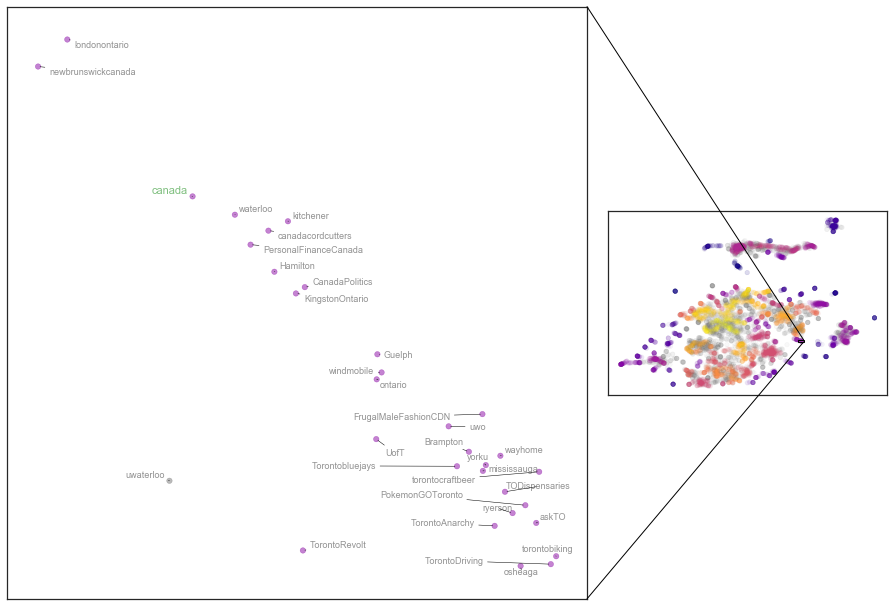

In [21]:
plot_cluster(subreddit_map_df, 'canada')

That's interesting, but it seems very Toronto-centric (although I'm sure many Torontonians consider Toronto to be the only part of Canada that matters). We do see the core Toronto subreddits clustered more to the bottom right corner, with more general Ontario subreddits (``r/Guelph``, ``r/KingstonOntario``, ``r/kitchener`` and ``r/waterloo``) further up and to the left. Interestingly my Alma Mater, the University of Western Ontario (``r/uwo``), falls in amongst the Toronto subreddits, and not up in the top left next to ``r/londonontario`` (the city in which the university is actually located). Perhaps that says something about the subculture that populates the uwo subreddit, such as the fact that many UWO students are from Toronto. A final interesting point: the ``r/toronto`` subreddit itself doesn't feature here. Where did it end up?

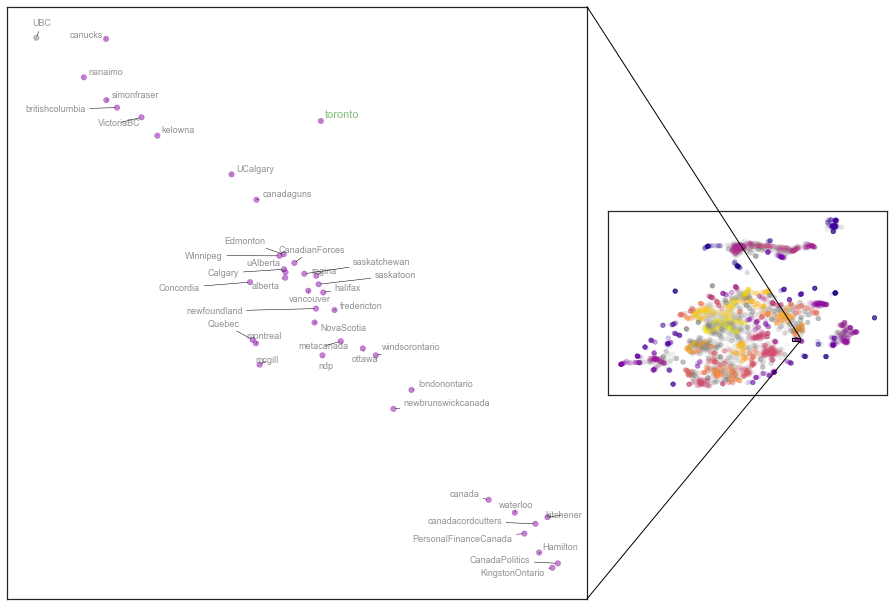

In [22]:
plot_cluster(subreddit_map_df, 'toronto')

Ah, we found the rest of Canada! From the overview map (and even from the context in the bottom right corner) we can see that it is right next to the previous canada cluster, just a little separated. We can also note that we get a general westward trend as me move to the left, with BC related subreddits making up the upper left corner. We also have ``r/canadaguns`` somewhere between ``r/Edmonton`` and ``r/UCalgary`` -- one can perhaps speculate about gun enthusiasts and  conservative Alberta. The final thing to note here is that the actual ``r/toronto`` subreddit is a bit of an outlier even here. Perhaps the subreddit has a slightly different subculture than the rest of the more specific Toronto subreddits? Certainly a question that might be delving into in more depth with a specific analysis of that subreddit.

Let's move on to other things I'm interested in. How about machine learning -- where does that live?

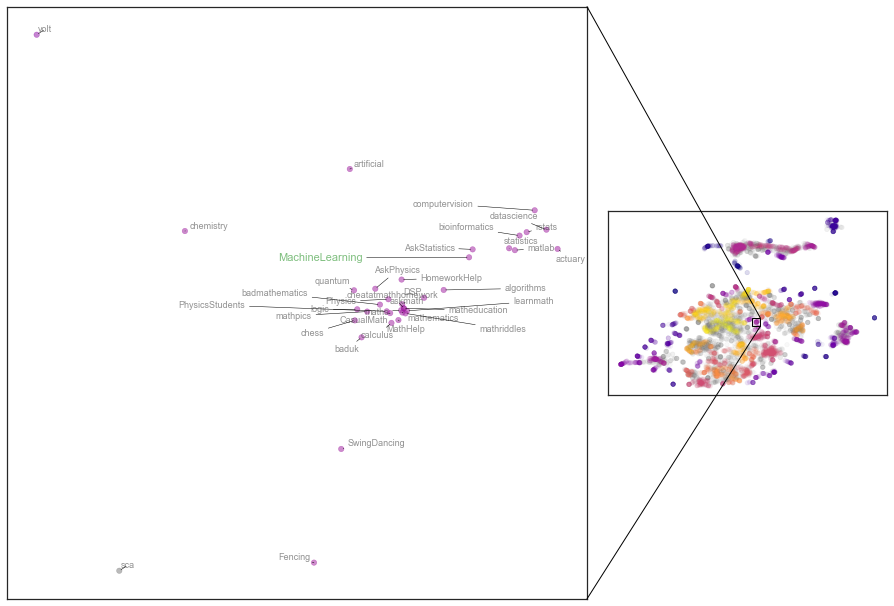

In [23]:
plot_cluster(subreddit_map_df, 'MachineLearning')

Now we're much more in the middle of the map, and we have a strong math and science bent to things. There's plety of math related subreddits, with a mix of stats, data science and computer science mixed in. Perhaps more interesting are some of the other subreddits that appear here: right in the middle of the clump is the ``r/chess`` subreddit. Perhaps not unexpected? How about ``r/SwingDancing``  and ``r/Fencing`` in the lower portion? There might be some interesting overlap in those communities. My personal anecdotal experience has most of the mathematicians I know also interested in rock climbing -- that doesn't appear here though. So where do we find climbing?

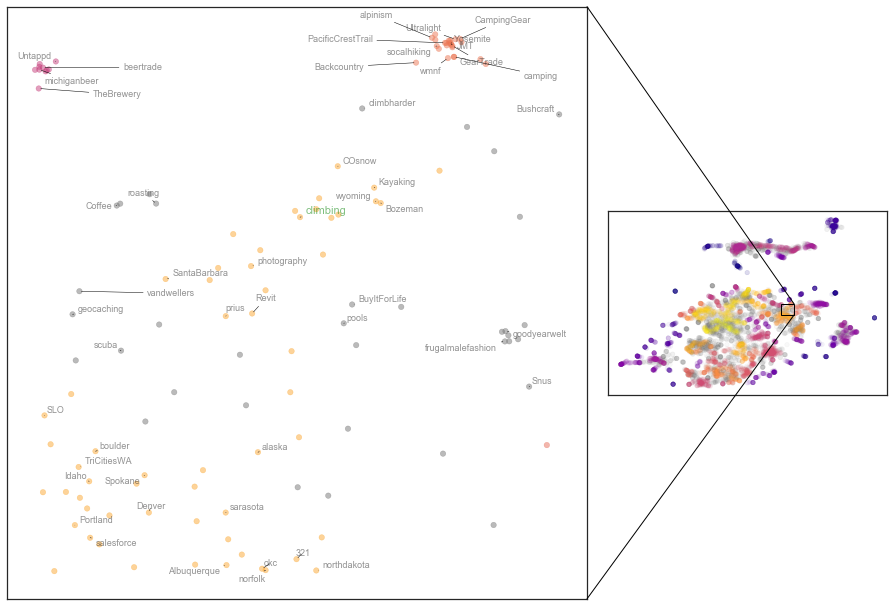

In [24]:
plot_cluster(subreddit_map_df, 'climbing')

It's in the outdoors cluster -- although we can see the specific hiking/camping cluster in the top right corner is separate and more tightly packed together. Also worth noting is how explicitly North American this all is. Why ``r/salesforce`` shows up in this cluster is a mystery to me; perhaps that is another opportunity for drilling down into more specific data as there may well be an interesting explanation. Finally, apparently related to outdoors in the upper left is ... beer?

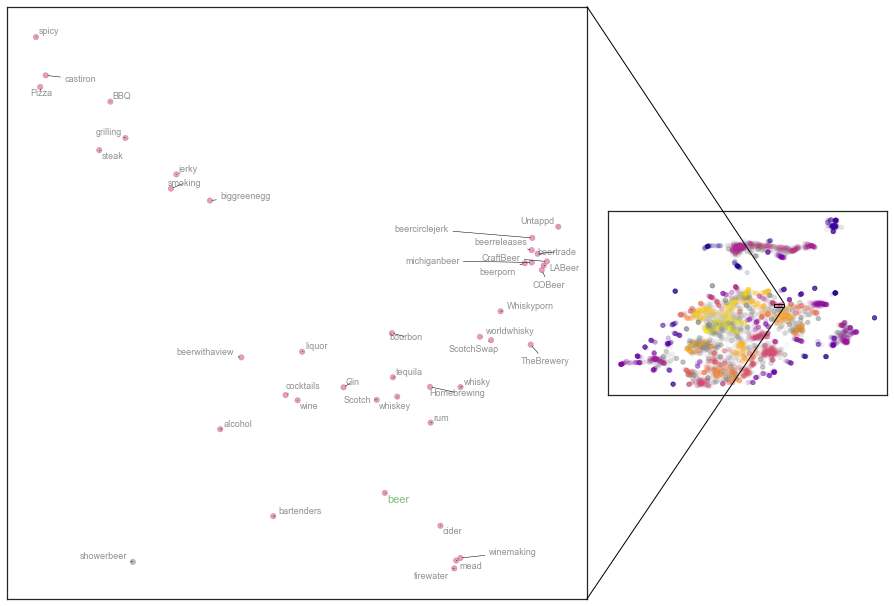

In [25]:
plot_cluster(subreddit_map_df, 'beer')

It seems we just caught the corner of the beer cluster last time -- the actual cluster includes not just beer, but general alcoholic drinks with different parts of the cluster devoted to beer and spirits. Oddly enough the upper left part of this cluster seems to be all about smoking food and barbecuing. It would seem that the sort of users who enage in beer and alcohol specific subreddits also enjoy outdoor cooking.

Enough with following that particular line of coincidences; let's move somewhere else. How about programming?

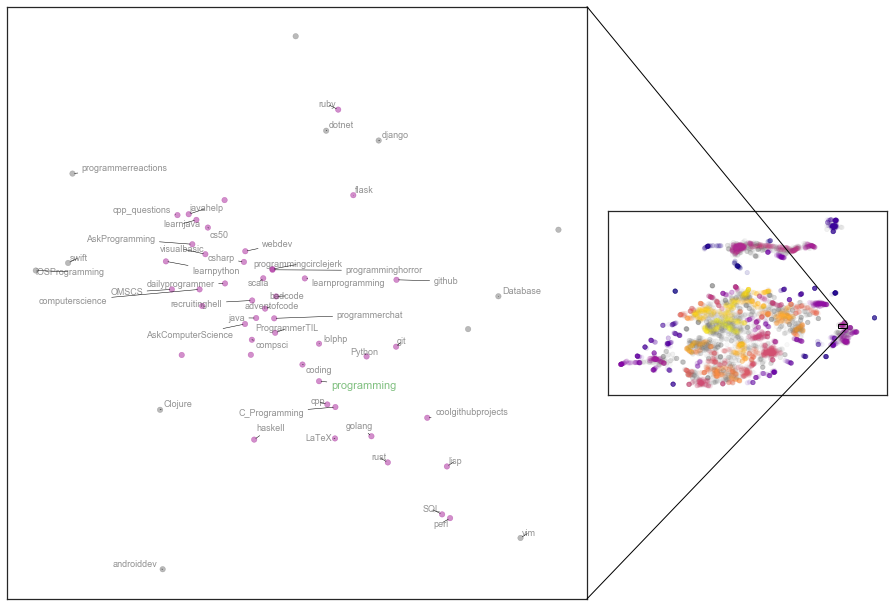

In [26]:
plot_cluster(subreddit_map_df, 'programming')

Well this looks much like one might reasonably expect -- a great many of the programming and programming related subreddits all fall closely together here, with the popular programming subreddit near the center of it all. In practice the fringes of this cluster provide some of the more interesting information. Things that are nearby but don't quite make the main cluster include ``r/programmerreactions`` and ``r/Database``, but also ``r/swift``, ``r/iOSprogramming`` and ``r/androiddev``. It seems that developing for mobile devices has a slightly different subcommunity associated to it than the bulk of programming subreddits. It's also worth noting that, as seen in the overview plot to the right, we are looking at a subcluster of a large group that is somewhat disjoint from the main body of subreddits. We might reasonably expect some of the other clusters amongst that group to also be tech oriented. Since mobile device communities seemed to be a little distinct let's search for some of those ...

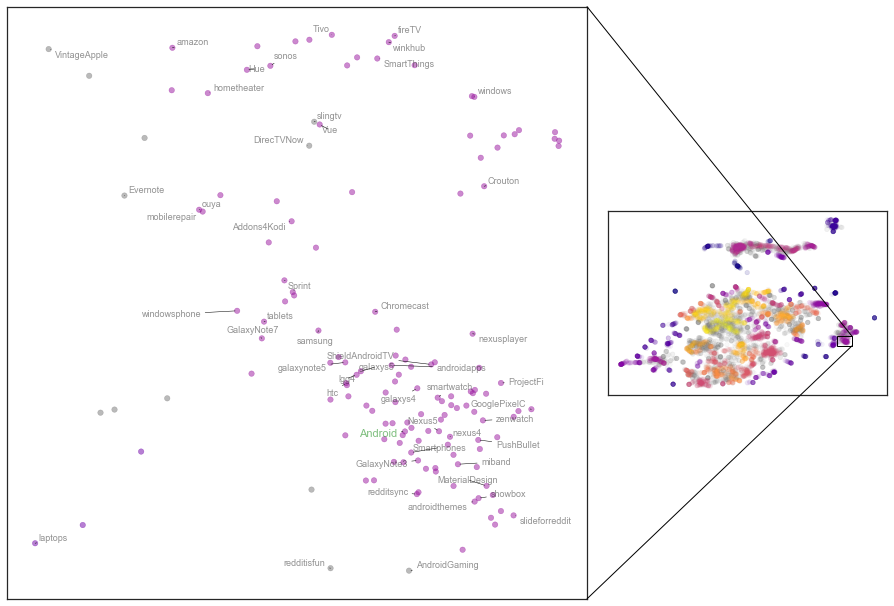

In [27]:
plot_cluster(subreddit_map_df, 'Android')

If you check the right hand overview plot you can see we are still in that large separated group, but now down closer to the bottom of it. And indeed we have a cluster focussed around mobile devices -- but broader than that. ``r/Hometheater``, ``r/fireTV`` and ``r/Tivo`` all appear nearby at the top of the frame. Similarly, part of another nearby cluster to the left, we can see laptops just making the frame. But enough of Android -- one would reasonably expect the iphone community to be fairly disjoint so let's see if that's the case.

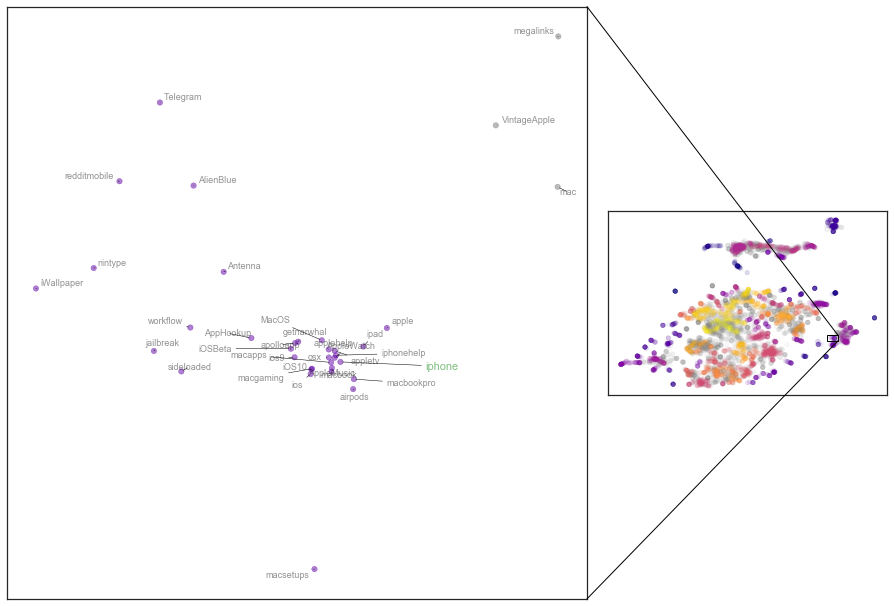

In [28]:
plot_cluster(subreddit_map_df, 'iphone')

From the overview we see that we are in a nearby (but clearly slightly separate) part of the larger separated group -- and it contains not just iphone, but all things apple. Also getnarwhal, whatever that is (perhaps someone more in tune with the appropriate subculture could fill me in on that one). 

I think I've demonstrated how well the dimension reduction and clustering have worked, but you shouldn't take my word for it. You can explore further yourself in the interactive plot. I'm sure there are plenty more interesting stories to tell, especially if you're willing to go and dig a little deeper into the source data on BigQuery to follow up on some of the things we've found here. Some suggestions for things to look for: gun enthusiasts form their own cluster, and that may have interesting structure; photography enthusiasts are also a fairly distinct group; looking more mainstream, the structure of clusters associated to, say, film and TV (hint genres provide structure), or music, also might be interesting. If you're following along in an active notebook then we can make use of [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) to make a one-line with text input for you to search out subreddit clusters yourself -- just run the cells below to get it started, and search away. Unfortunately this won't work for those reading on nbviewer, but perhaps that's motivation to get Jupyter notebook running and try it our for yourself!

In [29]:
from ipywidgets import interact_manual, fixed, Text

In [30]:
interact_manual(plot_cluster, 
                dataframe=fixed(subreddit_map_df), 
                subreddit=Text())

<function __main__.plot_cluster>

For those not following along in a live notebook we'll pick out some interesting clusters and display all of them. How do we find interesting clusters? The clustering algorithm HDBSCAN\* supports a notion of cluster coherence -- how strongly or tightly a cluster holds together before breaking apart (either into subclusters, or noise). We can sort the cluster coherence scores and look at the top ten most coherent clusters. These should be the clusters that are the most cleanly grouped as distinct from everything else around them. To start we'll look at a bar plot of the cluster coherence scores (in descending order of coherence) for the top 10 most coherent clusters.

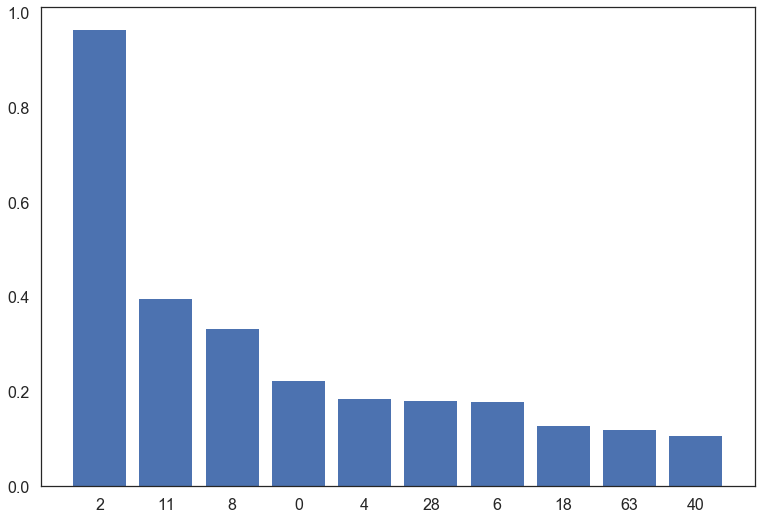

In [31]:
coherent_clusters = np.argsort(clusterer.cluster_persistence_)[-10:][::-1]
coherence = np.sort(clusterer.cluster_persistence_)[-10:][::-1]
ax = plt.subplot(111)
ax.bar(np.arange(10), coherence)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(coherent_clusters);

So cluster 2 is very coherent, and after that things tend to fall away and level off. Now that we have the list of the ten most coherent clusters we can have a look at them all. A quick function will make the process much easier.

In [32]:
def plot_cluster_by_id(dataframe, cluster_id):
    subreddits_in_cluster = np.array(dataframe.subreddit[cluster_ids == cluster_id])
    plot_cluster(dataframe, subreddits_in_cluster[0])
    plt.gcf().text(0.5, 0.98, 'Cluster {}'.format(cluster_id), ha='center')

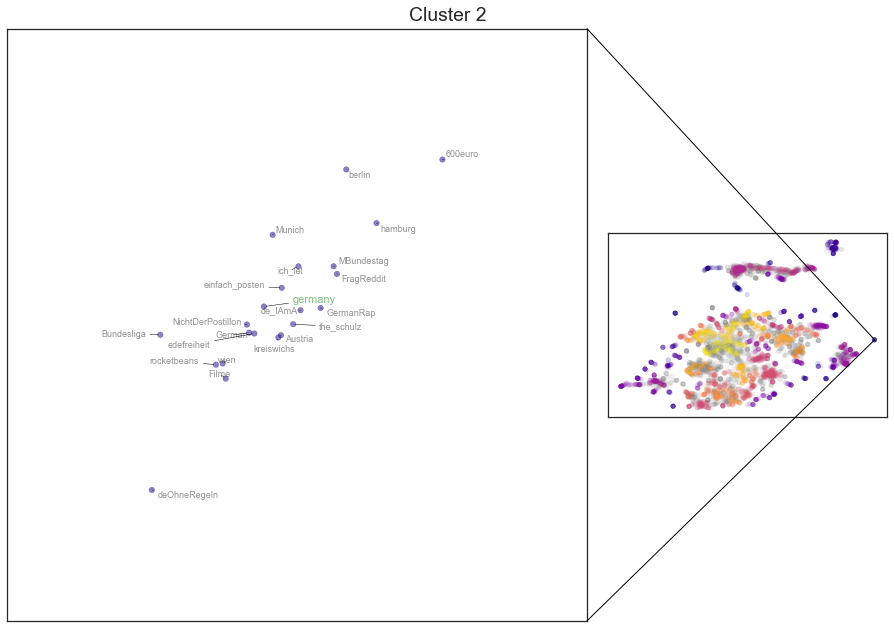

In [33]:
plot_cluster_by_id(subreddit_map_df, 2)

It would appear that the German subreddits, way out on the right hand side of the map, are the subreddits that clump together very tightly and share little in the common with any other subreddits. Perhaps this is to be expected, especially if they are German language subreddits. One presumes that other foreign language subreddits didn't make the top 10,000, or potentially have users that venture more into English language subreddits as well.

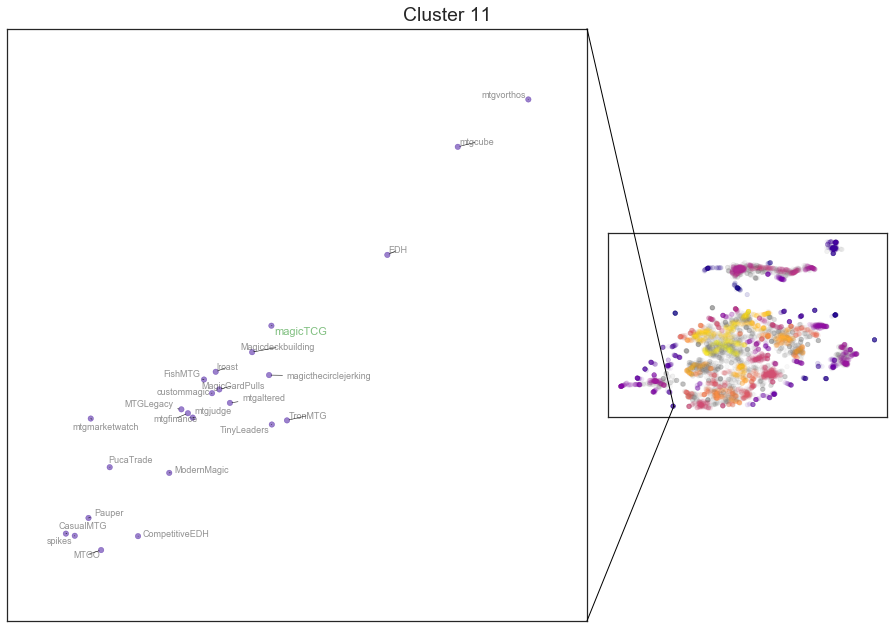

In [34]:
plot_cluster_by_id(subreddit_map_df, 11)

It is perhaps not surprising that a cult card game like Magic the Gathering has a distinctive and dedicated subculture. There may be some interesting stories to tell about those few subreddits that made the cluster but are floating away from the group: ``r/EDH``, ``r/mtgcube`` and ``r/mtgvorthos``.

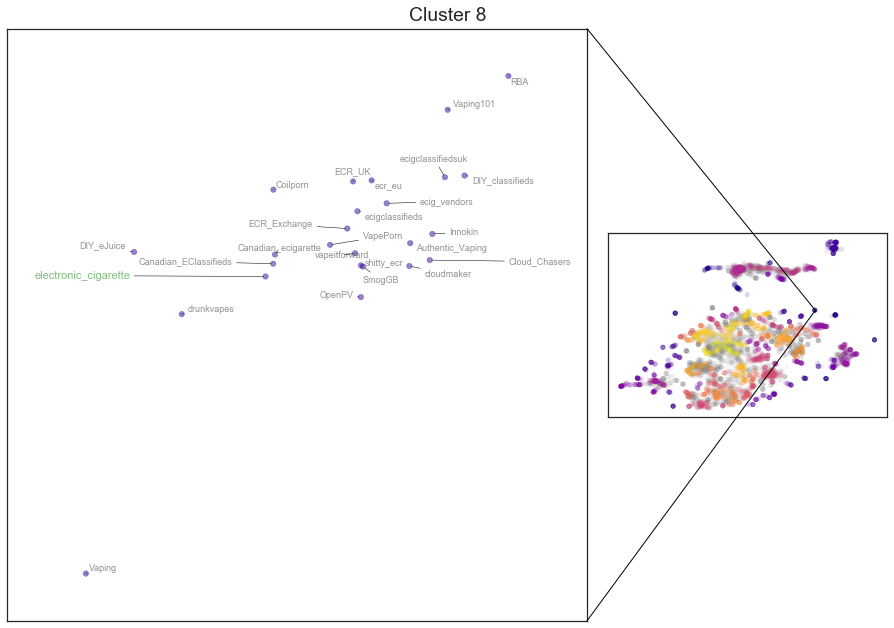

In [35]:
plot_cluster_by_id(subreddit_map_df, 8)

Again, we have another dedicated cult subculture making up a tightly knit and distinct cluster of subreddits. This time it is the e-cigarette subculture. Plausibly the subreddit ``r/Vaping`` is the more mainstream subreddit shunned by the hardcare devotees?

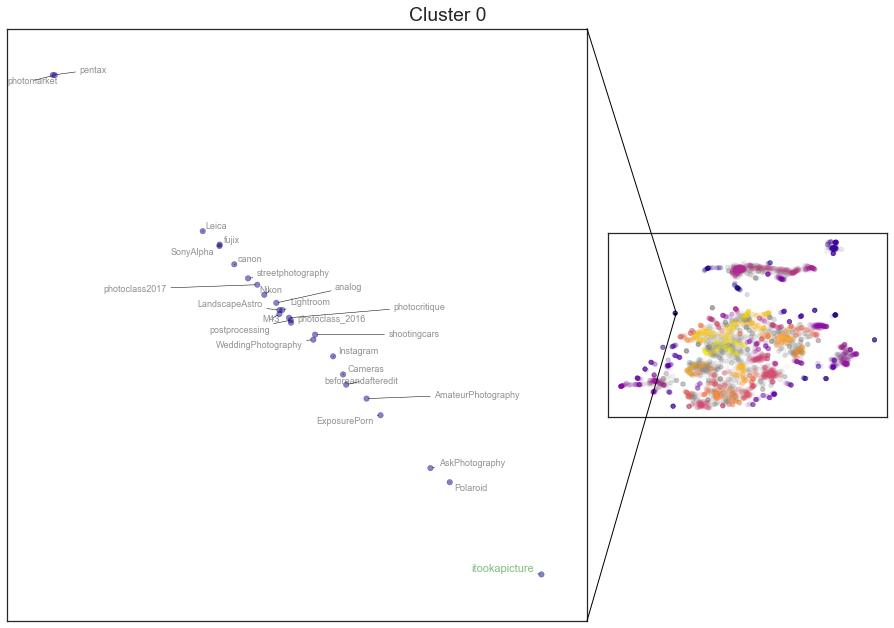

In [36]:
plot_cluster_by_id(subreddit_map_df, 0)

We found the photographers! All stretched out in a line rather than clumped together it ranges from general photography (``r/itookapicture``, '``r/Polaroid``, and ``r/AskPhotography``) up to brand specific subreddits like ``r/Leica``, ``r/fujix`` and ``r/Nikon``.

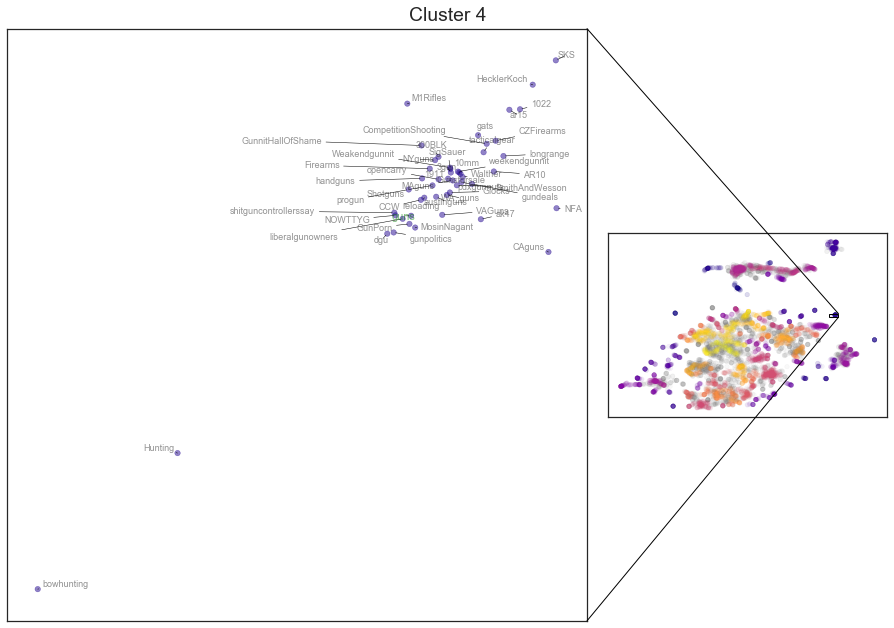

In [37]:
plot_cluster_by_id(subreddit_map_df, 4)

This is clearly the gun subculture subreddits all grouped together. It forms a tightly knit group well separated from the bulk of subreddits and has no particular internal structure (compared to, for example, the photography cluster which spread out linearly). It's interesting that ``r/Hunting`` and ``r/bowhunting`` made it into the cluster, albeit distant from the main mass.

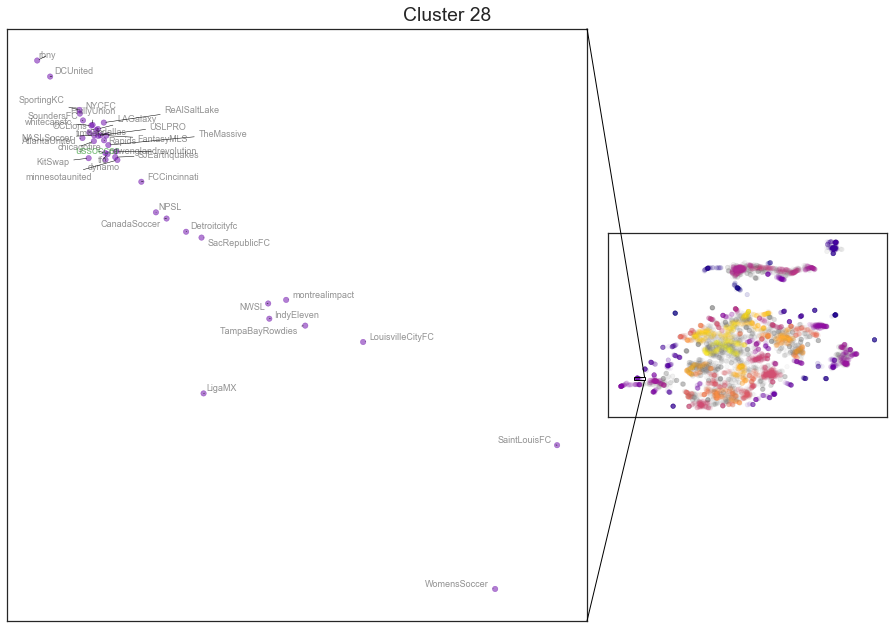

In [38]:
plot_cluster_by_id(subreddit_map_df, 28)

North American soccer makes up the next cluster. The neighboring cluster just below (as seen the the overview map on the right) is European soccer subreddits -- however they are close to clusters of European subreddits, making the stretched linear clump you see in the map. In contrast the Noth American soccer subreddit it well separated from everything else. It doesn't have much similarity to other US sport subreddits, and yet is quitea distinct subculture fro the general soccer subreddits (European soccer followers apparently have little interest in North American soccer).

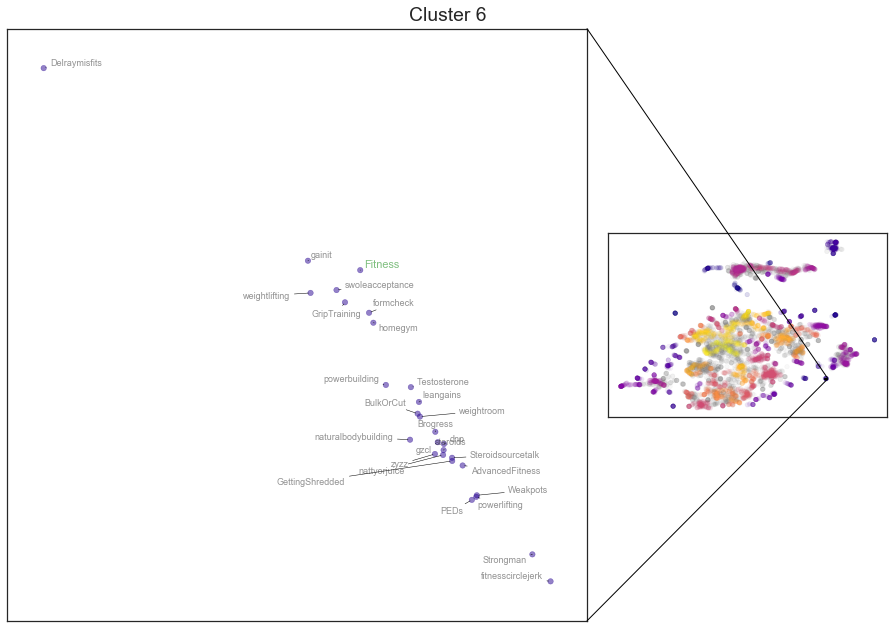

In [39]:
plot_cluster_by_id(subreddit_map_df, 6)

Here is a distinct fitness subreddit. As it happens this is a very male dominated set of subreddits (as can be inferred from ``r/Testosterone``, ``r/Brogress``, and the focus on weightlifting). You can find a different cluster of fitness subreddits that are more focussed on geenral fitness much closer to the general mass in the center.

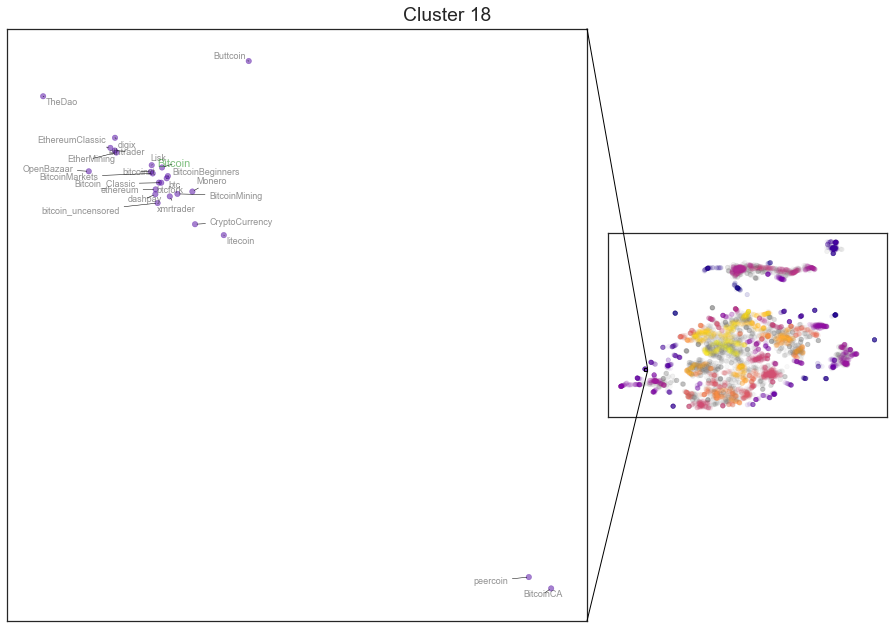

In [40]:
plot_cluster_by_id(subreddit_map_df, 18)

Bitcoin and related crypto-currencies are certainly something we would potentially expect to be a very separate subculture, and indeed they are here. It might be interesting to explore what makes ``r/BitcoinCA`` and ``r/peercoin`` somewhat different from the other cryptocurrency subreddits.

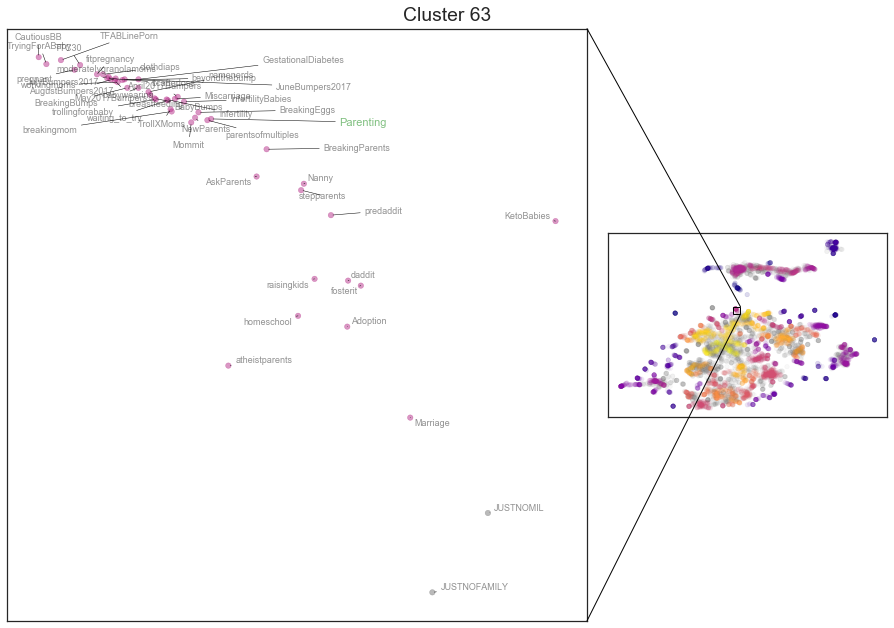

In [41]:
plot_cluster_by_id(subreddit_map_df, 63)

Parenting, esepcially of newborns (as can be noted by the pregnancy and 'baby bump' related subreddits in the top left corner) is a challeneging task indeed, something for which one can delve into whatever support subcultures one can find. They all cluster together very tightly here with various pregancy support subreddits making up th uppe left, spreading into newborns and general parenting as we move down and to the right, including ``r/homeschool`` and ``r/atheistparents`` quite close to each other .

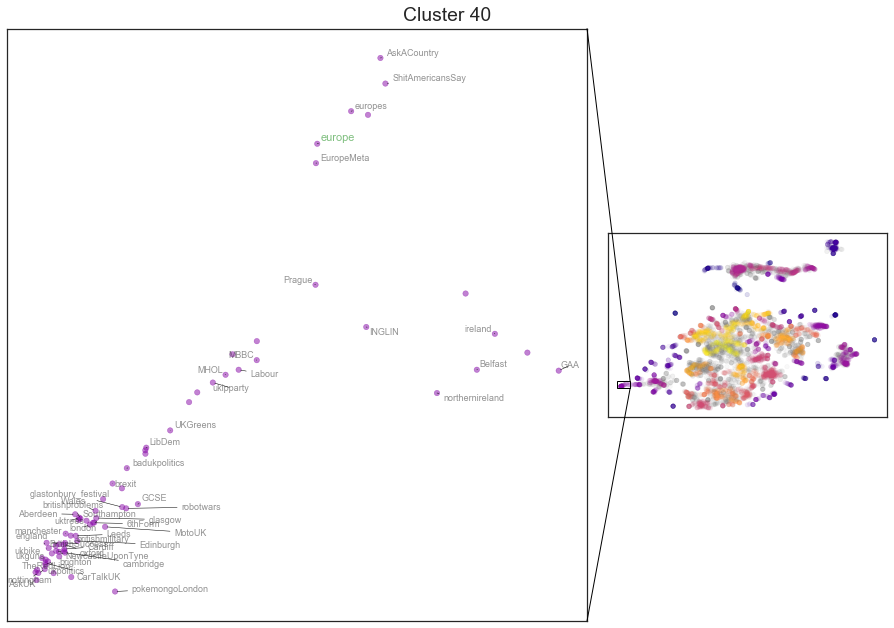

In [42]:
plot_cluster_by_id(subreddit_map_df, 40)

Reddit, at least as far as the top 10,000 subreddits are concerned, is very English language dominated. You can see that in effect here with a cluster that is ostensibly European in the upper right corner, but as we move along the linear cluster down and to the let we move toward the tightly knit heart of the cluster which is almost entirely British subreddits. Interestingly Irish subreddits spearate off to the right somewhat, while Scottish subreddits (such as ``r/glasgow`` and ``r/Edinburgh``) are in amongst the other British subreddits despite potential independence votes.

This brings us to a close of the top 10 most coherent clusters, and a close on our analysis for now. I hope this has been a useful demonstration of the power of machine learning in analysing data and finding useful or interesting stories to tell about the data amidst the large mass of information. Remember data science is a team sport, and we can all play!

As a final note, this notebook presents a fairly direct path that quickly gives us the analysis we want. In case you thought it all went just as smoothly as the final presentation here, fear not -- I explored several different approaches before settling on the one presented here. My initial efforts were very similar to what you see here, but used t-SNE not LargeVis; I also explored using positive pointwise mutual information instead of l1 normalized vectors, and simply taking variations of the conditional probability matrix of the overlaps as the starting point for t-SNE (no distance computations required). Each of these options were inferior in some way, but I've preserved the experiments in [notebooks on github](https://github.com/lmcinnes/subreddit_mapping) so you can see what I tried and failed before embarking on your own analysis superior to this one.